In [2]:
import numpy as np
from osgeo import gdal
from pydevd import settrace

"""
functions:
- total - ok
- median - ok
- minimum - ok
- maximum - ok
- range - ok
- Majority
- Minority
- standard deviation
- variation

"""
"""
GDALDataType:
GDT_Unknown = 0, GDT_Byte = 1, GDT_UInt16 = 2, GDT_Int16 = 3, 
GDT_UInt32 = 4, GDT_Int32 = 5, GDT_Float32 = 6, GDT_Float64 = 7, 
GDT_CInt16 = 8, GDT_CInt32 = 9, GDT_CFloat32 = 10, GDT_CFloat64 = 11, 
GDT_TypeCount = 12
"""

dataTypes = {gdal.GDT_Byte : int, #@UndefinedVariable
            gdal.GDT_UInt16 : int, #@UndefinedVariable
            gdal.GDT_Int16 : int, #@UndefinedVariable
            gdal.GDT_UInt32 : int, #@UndefinedVariable
            gdal.GDT_Int32 : int, #@UndefinedVariable
            gdal.GDT_Float32 : float, #@UndefinedVariable
            gdal.GDT_Float64 : float, #@UndefinedVariable
            gdal.GDT_CInt16 : np.complex,
            gdal.GDT_CInt32 : np.complex,
            gdal.GDT_CFloat32 : np.complex,
            gdal.GDT_CFloat64 : np.complex
            }

dataTypesFromInt = {0 : gdal.GDT_Byte,
                    1 : gdal.GDT_UInt16,
                    2 : gdal.GDT_Int16,
                    3 : gdal.GDT_UInt32,
                    4 : gdal.GDT_Int32,
                    5 : gdal.GDT_Float32,
                    6 : gdal.GDT_Float64,
                    7 : gdal.GDT_CInt16,
                    8 : gdal.GDT_CInt32,
                    9 : gdal.GDT_CFloat32,
                    10 : gdal.GDT_CFloat64
                    }

class rasterInfo(object):
    def __init__(self, gd=None, bandNr=1):
        if gd:
            band = gd.GetRasterBand(bandNr)

            self.maxValue = band.GetMaximum()
            self.minValue = band.GetMinimum()


            if self.maxValue is None or self.minValue is None:
                (self.minValue, self.maxValue) = band.ComputeRasterMinMax(1)

            self.meanValue = (float(self.maxValue)+self.minValue)/2

            self.noDataValue = band.GetNoDataValue()
            if self.noDataValue is None: self.noDataValue = self.minValue-1

            self.dataType = dataTypes[band.DataType]
            self.gdalDataType = band.DataType

            self.projection = gd.GetProjection()
            self.geoTransform = gd.GetGeoTransform()

def rasterSTD(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)
    (mh, mw) = mask.shape
    
    dx = mw//2
    dy = mh//2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

    (uh, uw) = u.shape

    out = np.zeros(u.shape, dtype=rInfo.dataType)

    for w in range(uw-dx-1):
        for h in range(uh-dy-1):
            s = u[h:h+mh,w:w+mw]#*mask
            s = s[s>=0]
            if len(s) == 0: continue #if all values are noDataValue then continue with next cell
            a = np.asarray(s)
            m = np.std(a) 
            out[h+dy,w+dx] = m
    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out[dy:-dy,dx:-dx]



def rasterSum(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)
    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1) #@UndefinedVariable
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)
    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)
    (uh, uw) = u.shape
    print(u.shape)
    out = np.zeros(u.shape, dtype=rInfo.dataType)

    for w in range(uw-dx):
        for h in range(uh-dy):
            s = u[h:h+mh,w:w+mw] #*mask
            s = s[s>=0]
            if len(s) == 0: 
                continue #if all values are noDataValue then continue with next cell
            else:
                m = np.sum(s)
                out[h+dy,w+dx] = m

    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out[dy:-dy,dx:-dx]



def rasterMax(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)  

    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    #wm = dx*2
    #hm = dy*2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.minValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.minValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.minValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.minValue, axis=0)


    out = np.zeros(u.shape, dtype=rInfo.dataType)
    out[:,:] = rInfo.minValue
    
    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[-(y+1),-(x+1)] != 0:
                out[dy:-dy, dx:-dx] = np.maximum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    rOut = out[dy:-dy,dx:-dx]
    del out
    return rOut


def rasterMin(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)

    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    #wm = dx*2
    #hm = dy*2
    #print u

    for x in range(dx):
        u = np.insert(u, 0, rInfo.maxValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.maxValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.maxValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.maxValue, axis=0)

    out = np.zeros(u.shape, dtype=rInfo.dataType)
    out[:,:] = rInfo.maxValue


    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[-(y+1),-(x+1)] != 0:
                out[dy:-dy, dx:-dx] = np.minimum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    rOut = out[dy:-dy,dx:-dx]
    del out
    return rOut



def rasterRange(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)

    (mh, mw) = mask.shape
    dx = mw//2
    dy = mh//2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

    out = np.zeros(u.shape, dtype=rInfo.dataType)
    out[:,:] = rInfo.noDataValue

    for x in range(mask.shape[1]):
        for y in range(mask.shape[0]):
            if mask[-(y+1),-(x+1)] != 0:
                out[dy:-dy, dx:-dx] = np.maximum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])-np.minimum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])


    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out[dy:-dy,dx:-dx]



def rasterMedian(raster, mask, rInfo, iterations=1):
    u = raster
    noDataArray = np.where(u < 0)

    (mh, mw) = mask.shape

    dx = mw//2
    dy = mh//2
    #wm = dx*2
    #hm = dy*2

    for x in range(dx):
        u = np.insert(u, 0, rInfo.noDataValue, axis=1)
        u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

    for y in range(dy):
        u = np.insert(u, 0, rInfo.noDataValue, axis=0)
        u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

    (uh, uw) = u.shape
    #print u, hm, wm

    out = np.zeros(u.shape, dtype=rInfo.dataType)

    for w in range(uw-dx-1):
        for h in range(uh-dy-1):
            s = u[h:h+mh,w:w+mw]#*mask
            s = s[s>=0]
            if len(s) == 0: continue #if all values are noDataValue then continue with next cell

            p = list(s)
            p.sort()
            l = len(p)
            l2 = l//2

            if l%2:
                m = p[l2]
            else:
                m = float((p[l2])+p[l2-1])/2
            out[h+dy,w+dx] = m


    out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue

    return out[dy:-dy,dx:-dx]



def rasterAverage(raster, mask, rInfo, iterations=1):
    raster = u
    noDataArray = np.where(u < 0)
    
    count = simpleMaskCount(raster.shape, mask.shape, noDataArray)

    out = rasterSum(raster, mask, rInfo)/count

    out[noDataArray[0], noDataArray[1]] = rInfo.noDataValue
    return out 


def simpleMaskCount(rasterShape, maskShape, noDataArray):
    (rY, rX) = rasterShape
    #rY = rasterShape[0]
    (mY, mX) = maskShape
    #mY = maskShape[0]

    out = np.zeros(rY*rX, dtype=int).reshape(rY,rX)
    count = mY*mX

    dx = mX//2
    dy = mY//2
    #wm = mX-1
    #hm = mY-1
    #print (dx, dy, wm, hm)
    
    out[dy:-dy,dx:-dx] = count


    for x in range(dx):
        out[dy:-dy,x] = mY*(dx+1+x)
        out[dy:-dy,-x-1] = mY*(dx+1+x)


    for y in range(dy):
        out[y,dx:-dx] = (dy+1+y)*mX
        out[-y-1,dx:-dx] = (dy+1+y)*mX


    for x in range(dx):
        for y in range(dy):
            val = (dy+1+y)*(dx+1+x)
            out[y, x] = val
            out[-(y+1),-(x+1)] = val
            out[y, -(x+1)] = val
            out[-(y+1),x] = val

    tmp = np.zeros((rY+dy*2)*(rX+dx*2)).reshape(rY+dy*2,rX+dx*2)
    tmp[dy:-dy,dx:-dx] = out

    for i in range(len(noDataArray[0])):
        tmp[noDataArray[0][i]:noDataArray[0][i]+(2*dy)+1,noDataArray[1][i]:noDataArray[1][i]+(2*dx)+1] -= 1

    return tmp[dy:-dy,dx:-dx]


def mask_count(self):
    u = self.big_r #np.array(self.big_r, copy=True)
    dx = self.size_x
    dy = self.size_y
    wm = dx*2
    hm = dy*2
    out = np.zeros(u.shape, dtype=float32)

    c = list(self.mask.flatten()).count(0)
    out[hm:-hm,wm:-wm] = self.mask.size-c

    for x in range(dx):
        c = list(self.mask[:, dx-x:].flatten()).count(0)
        out[hm:-hm,x+dx] = self.mask[:, dx-x:].size-c
        c = list(self.mask[:, :dx+1+x].flatten()).count(0)
        out[hm:-hm,-(x+1+dx)] = self.mask[:, :dx+1+x].size-c
    for y in range(dy):
        c = list(self.mask[dy-y:, :].flatten()).count(0)
        out[y+dy,wm:-wm] = self.mask[dy-y:, :].size-c
        c = list(self.mask[:dy+1+y, :].flatten()).count(0)
        out[-(y+1+dy),wm:-wm] = self.mask[:dy+1+y, :].size-c
        #rogi
    for x in range(dx):
        for y in range(dy):
            c = list(self.mask[dy:, dx-x:].flatten()).count(0)
            out[y+dy, x+dx] = self.mask[dy:, dx-x:].size-c
            
            c = list(self.mask[:dy+y+1, :dx+x+1].flatten()).count(0)
            out[-(y+1+dy),-(x+1+dx)] = self.mask[:dy+y+1, :dx+x+1].size-c
            
            c = list(self.mask[:dy+y+1, dx-x:].flatten()).count(0)
            out[-(y+1+dy), x+dx] = self.mask[:dy+y+1, dx-x:].size-c

            c = list(self.mask[dy:, :dx+x+1].flatten()).count(0)
            out[y+dy, -(x+1+dx)] = self.mask[dy:, :dx+x+1].size-c

    rast_nan = np.where(u[dy:-dy,dx:-dx]==self.noDataValue)
    rast_nan = (rast_nan[0]+dy,rast_nan[1]+dx)
    rev_mask = np.fliplr(self.mask[::-1])

    for i in range(rast_nan[0].size):
        ry = rast_nan[0][i]
        rx = rast_nan[1][i]
        out[ry-dy:ry+dy+1,rx-dx:rx+dx+1] -= rev_mask

    return out[dy:-dy,dx:-dx]


def SaveToFile(FileName, raster, rInfo, type_raster=None):
    format_raster = "GTiff"
    driver = gdal.GetDriverByName(format_raster)
    if type_raster != None:
        dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, dataTypesFromInt[type_raster], ['COMPRESS=DEFLATE'] )
    else:
        dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, rInfo.gdalDataType, ['COMPRESS=DEFLATE'] )
    dst_ds.SetGeoTransform( rInfo.geoTransform )
    dst_ds.SetProjection( rInfo.projection )
    if rInfo.noDataValue: dst_ds.GetRasterBand(1).SetNoDataValue( rInfo.noDataValue )
    dst_ds.GetRasterBand(1).WriteArray( raster )
    # Once we're done, close properly the dataset
    dst_ds = None
    

    
# def array2raster(raster,outputfilepath,array):
#     raster = gdal.Open(raster)
#     geotransform = raster.GetGeoTransform()
#     originX = geotransform[0]
#     originY = geotransform[3]
#     pixelWidth = geotransform[1]
#     pixelHeight = geotransform[5]
#     cols = raster.RasterXSize
#     rows = raster.RasterYSize

#     driver = gdal.GetDriverByName('GTiff')
#     outRaster = driver.Create(FileName, cols, rows, 1, gdal.GDT_Float32)
#     outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
#     outband = outRaster.GetRasterBand(1)
#     outband.WriteArray(array)
#     outRasterSRS = osr.SpatialReference()
#     outRasterSRS.ImportFromWkt(raster.GetProjectionRef())
#     outRaster.SetProjection(outRasterSRS.ExportToWkt())
#     outband.FlushCache()

def focal_stats(input_raster_path, dimension, focal_function,output_raster_path = None):
    try:
        mask = np.ones(dimension)
    except:
        print("please input a valid dimension")
        return
    gd = gdal.Open(input_raster_path)
    raster = gd.ReadAsArray() #array with raster
    rInfo = rasterInfo(gd)
    switcher = {
        "mean": rasterAverage,
        "max": rasterMax,
        "min": rasterMin,
        "std": rasterSTD,
        "median": rasterMedian,
        "sum": rasterSum,
        "range": rasterRange
    }
    func = switcher.get(focal_function, lambda: "Invalid function name")
    rasteroutput = func(raster, mask, rInfo)
    if output_raster_path:
        print("The raster file has been exported to "+output_raster_path)
        SaveToFile(output_raster_path, rasteroutput, rInfo)
    return(rasteroutput)

## test run & plot

In [55]:
gd = gdal.Open('rainbowdist_historical_median.tif')
raster = gd.ReadAsArray() #array with raster
rInfo = rasterInfo(gd)

In [57]:
rInfo

In [166]:
# focal_stats have four parameters
# 1 - "input file path and name", 
# 2 - dimention in (n,n) format,
# 3 - function in quotation marks, like std/mean/max/min/median/range/sum
# 4 - optional output raster path and name, must be in the format of tiff, or the visualization will have issues

rasteroutput = focal_stats('rainbowdist_historical_median.tif',(3,3),"std",output_raster_path = "test.tif")

The raster file has been exported to test.tif


In [3]:
from matplotlib import pyplot
import rasterio
from rasterio.plot import show

<font color='red'>The below line shows the problem that the minimum which should be the no data value cannot be used to locate these no data values</font> 

In [180]:
raster == np.min(rasteroutput)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [178]:
raster

array([[ 4.49527931e+01,  1.81000004e+01,  2.06100006e+01, ...,
         2.04300003e+01,  2.06100006e+01,  2.35198822e+01],
       [ 5.62965622e+01,  1.63302288e+01,  1.36242437e+01, ...,
         1.32915115e+01,  1.35234652e+01,  1.85665817e+01],
       [ 3.59120369e+01,  1.27290430e+01,  1.12427225e+01, ...,
         1.09840679e+01,  1.10874014e+01,  1.85000000e+01],
       ...,
       [-3.39999995e+38, -3.39999995e+38,  1.39999998e+00, ...,
         2.34999990e+00,  2.08226180e+00,  1.76053429e+00],
       [ 1.00000000e+00, -3.39999995e+38, -3.39999995e+38, ...,
        -3.39999995e+38,  1.52785718e+00,  1.58749998e+00],
       [-3.39999995e+38, -3.39999995e+38,  2.90000010e+00, ...,
        -3.39999995e+38, -3.39999995e+38, -3.39999995e+38]], dtype=float32)

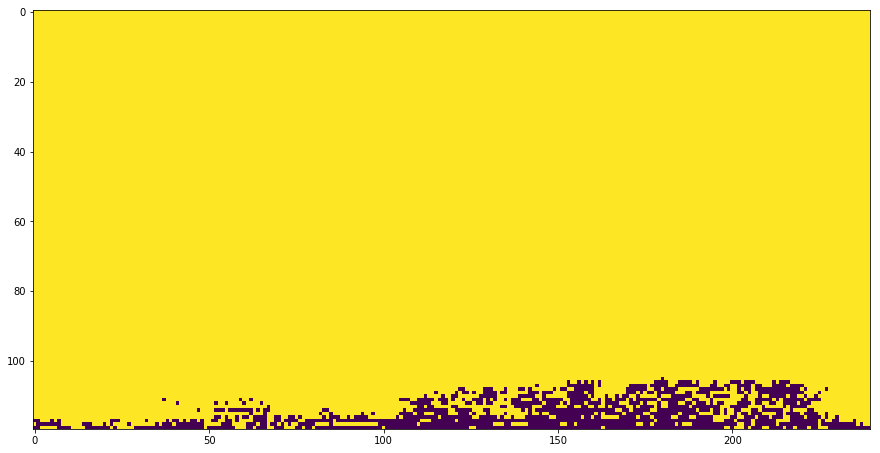

In [177]:
# run twice if not shown the first time
%matplotlib inline
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(rasteroutput)

# Issue Happens Here
### when open the output file, it looks like a different way. This can be resulted from the different NoData Values in the raster. Still working on this part.

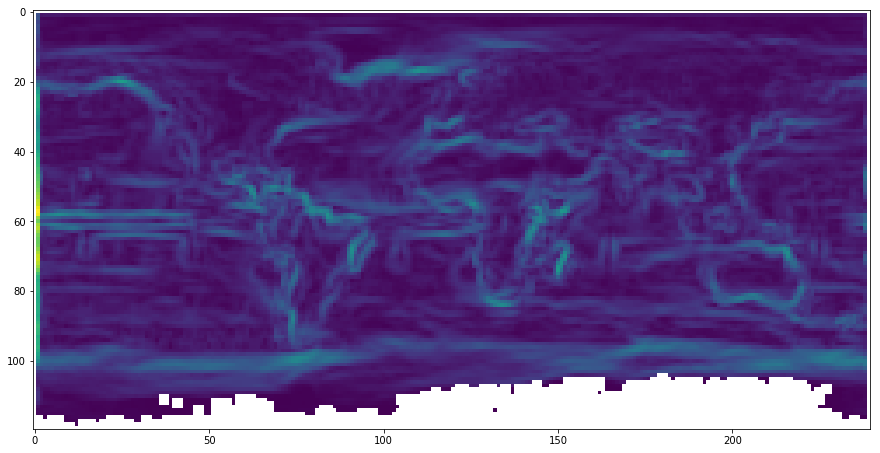

In [7]:
# run twice if not shown
from matplotlib import pyplot
import rasterio
from rasterio.plot import show
src = rasterio.open("test.tiff")
img=src.read()
img[img == src.nodata] = np.nan
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(img)

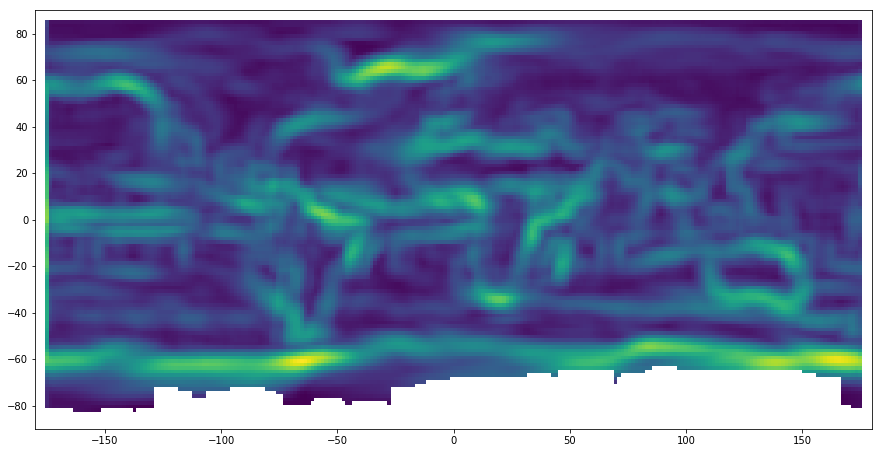

In [9]:
# run twice if not shown
from matplotlib import pyplot
import rasterio
from rasterio.plot import show
src2 = rasterio.open("test1.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(src2)

## it is wired that if I reload the test data and plot it again, it solves the issue. It is confusing and after trying for every possibility, the issues still exists. 

In [134]:
type_raster = None
FileName = "test_of_test.tif" # output file
rasterFile = 'test.tif'
gd = gdal.Open(rasterFile)
raster = gd.ReadAsArray() #array with raster
rInfo = rasterInfo(gd)

format_raster = "GTiff"
driver = gdal.GetDriverByName(format_raster)
if type_raster != None:
    dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, dataTypesFromInt[type_raster], ['COMPRESS=DEFLATE'] )
else:
    dst_ds = driver.Create( FileName, raster.shape[1], raster.shape[0], 1, rInfo.gdalDataType, ['COMPRESS=DEFLATE'] )
dst_ds.SetGeoTransform( rInfo.geoTransform )
dst_ds.SetProjection( rInfo.projection )
print(rInfo.noDataValue)
noDataValue = gd.GetRasterBand(1).GetNoDataValue()
print(noDataValue)
print(noDataValue==rInfo.noDataValue)
if rInfo.noDataValue: dst_ds.GetRasterBand(1).SetNoDataValue( rInfo.noDataValue )
dst_ds.GetRasterBand(1).WriteArray( raster )
# Once we're done, close properly the dataset
dst_ds = None

-3.4e+38
-3.4e+38
True


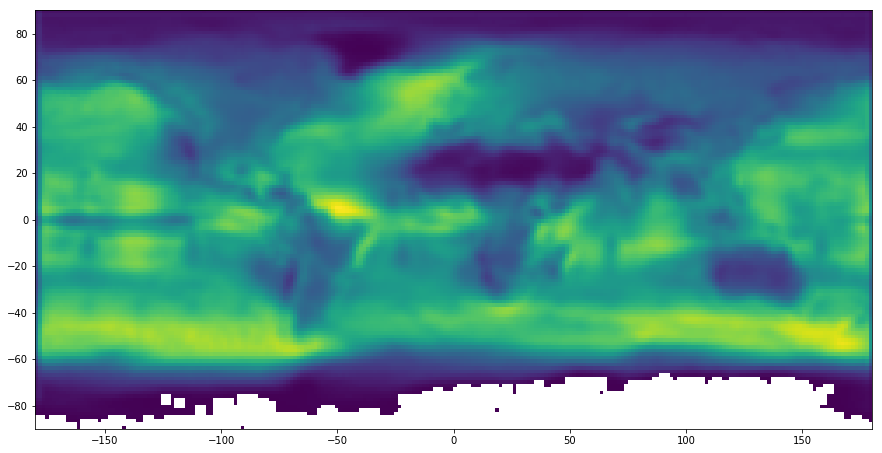

In [141]:
import rasterio
from rasterio.plot import show
src2 = rasterio.open("test_sum.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(src2)

## Some other tests for other functions

In [136]:
raster_sum = focal_stats('rainbowdist_historical_median.tif',(3,3),"sum",output_raster_path = "test_sum.tif")

(122, 242)
The raster file has been exported to test_sum.tif


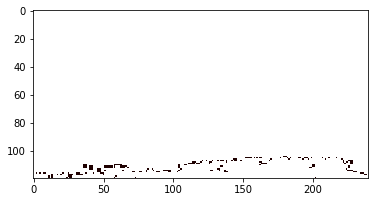

In [137]:
from matplotlib import pyplot
pyplot.imshow(src2.read(1), cmap='pink')

In [147]:
array_origin = rasterio.open('rainbowdist_historical_median.tif').read()[0]

In [157]:
array_origin[-3,13]

1.05625

In [160]:
array_origin[-4:-1,10:13]

array([[2.2714953, 2.427361 , 2.8484128],
       [1.425    , 1.       , 1.       ],
       [1.325    , 1.32     , 1.22     ]], dtype=float32)

In [156]:
raster_sum[-3,13]

-3.3999999521443642e+38

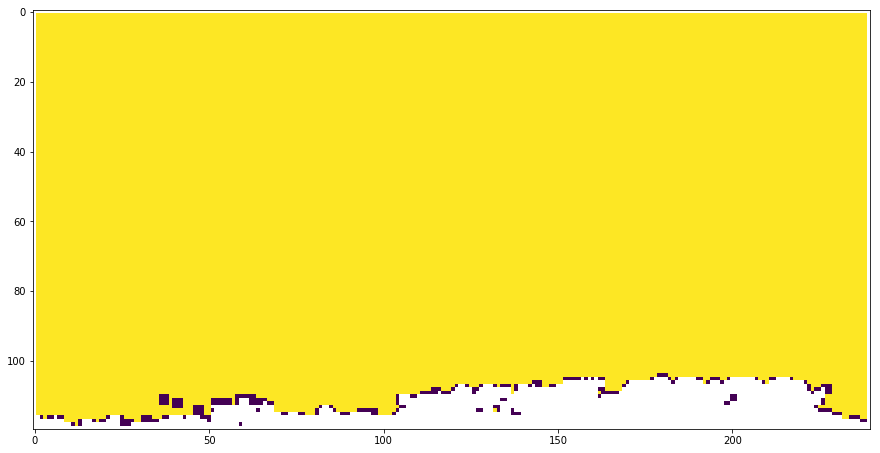

In [162]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_sum)

In [83]:
src2.shape

(120, 240)

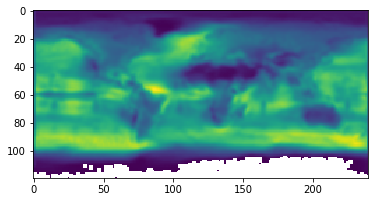

In [164]:
show(src2.read(masked=True))

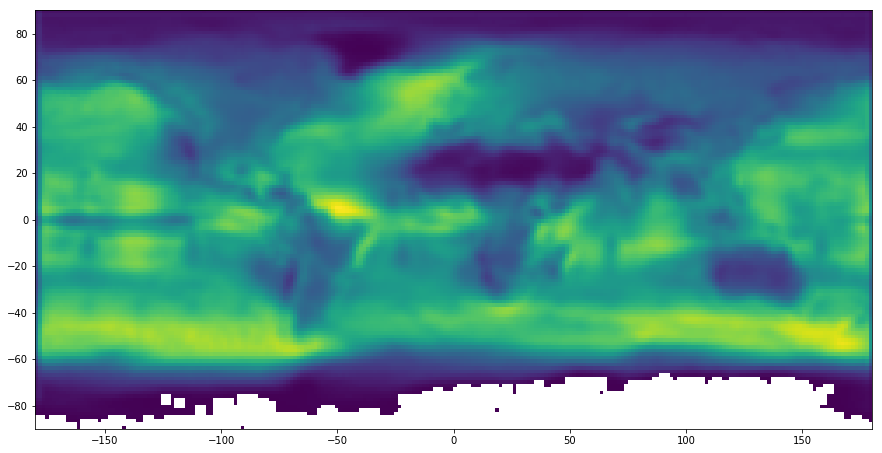

In [89]:
import rasterio
from rasterio.plot import show
src2 = rasterio.open("test_sum.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(src2)

In [50]:
raster_range = focal_stats('rainbowdist_historical_median.tif',(3,3),"range",output_raster_path = "test_range.tif")

The raster file has been exported to test_range.tif


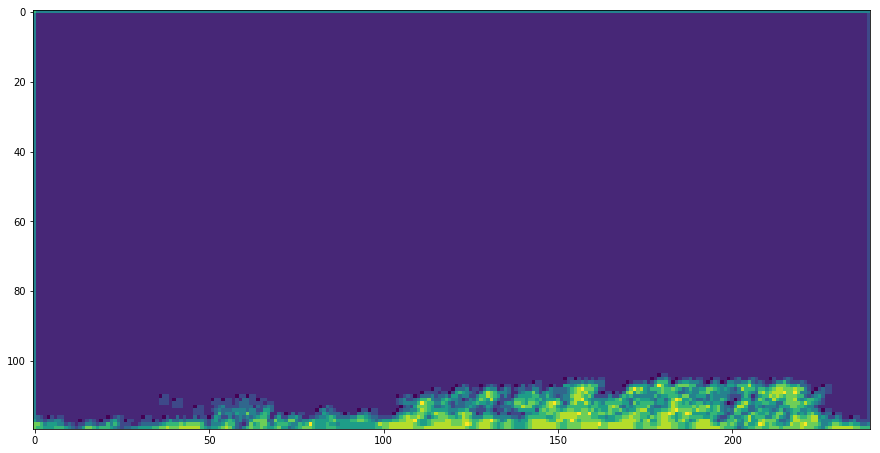

In [51]:
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_range)

The raster file has been exported to test_mean.tif


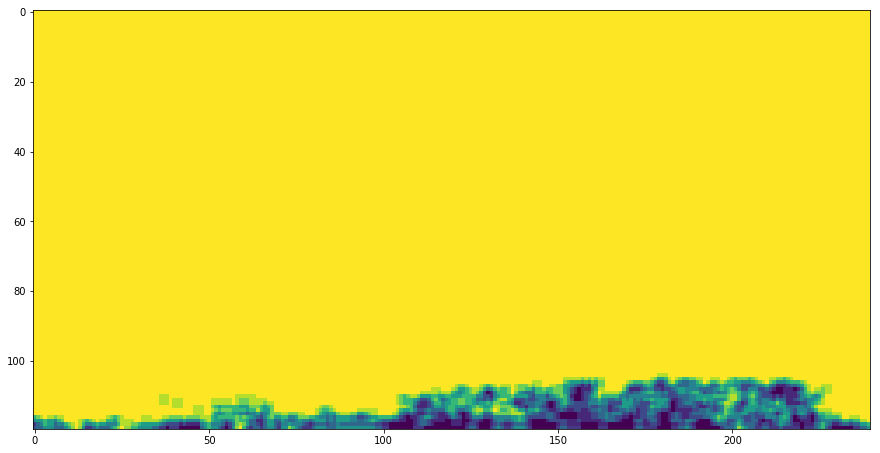

In [52]:
raster_mean = focal_stats('rainbowdist_historical_median.tif',(3,3),"mean",output_raster_path = "test_mean.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_mean)

The raster file has been exported to test_min.tif


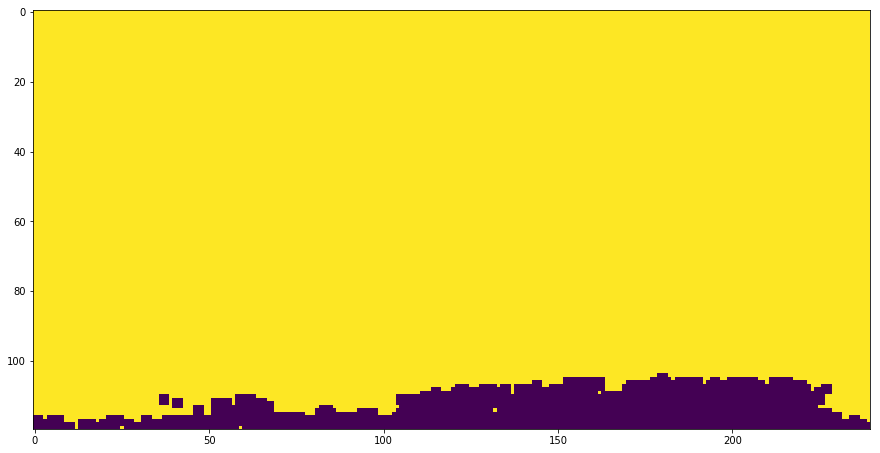

In [53]:
raster_min = focal_stats('rainbowdist_historical_median.tif',(3,3),"min",output_raster_path = "test_min.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_min)

The raster file has been exported to test_max.tif


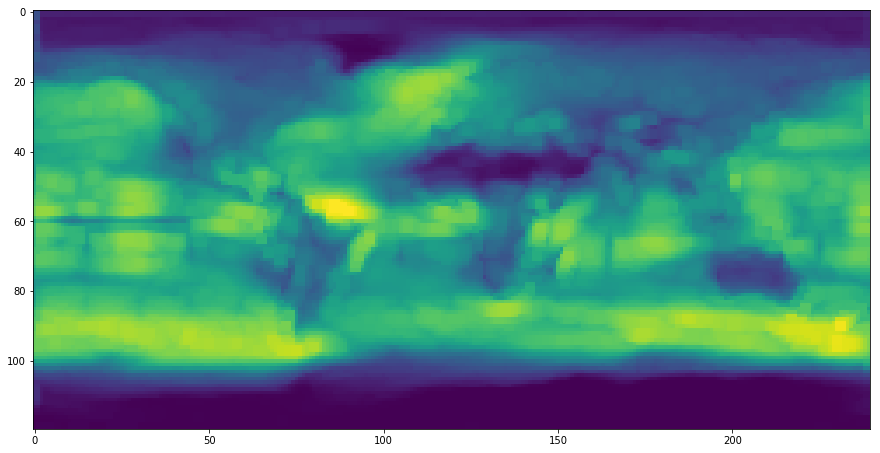

[[56.29656219 56.29656219 20.94000053 ... 20.61000061 23.5198822
  23.5198822 ]
 [56.29656219 56.29656219 20.94000053 ... 20.61000061 23.5198822
  23.5198822 ]
 [56.29656219 56.29656219 16.33022881 ... 13.93100071 18.56658173
  18.56658173]
 ...
 [ 1.17499995  1.39999998  1.82666671 ...  2.3499999   2.57285714
   2.57285714]
 [ 1.          2.9000001   2.9857142  ...  2.3499999   2.3499999
   2.0822618 ]
 [ 1.          2.9000001   2.9857142  ...  1.83028948  1.58749998
   1.58749998]]


In [54]:
raster_max = focal_stats('rainbowdist_historical_median.tif',(3,3),"max",output_raster_path = "test_max.tif")
fig, ax = pyplot.subplots(1, figsize=(15, 15))
show(raster_max)
print(raster_max)

# below are test codes

In [13]:
#################################Test codes


# if __name__ == '__main__':
#     #liczba kolumn i wierszy musi byc nieparzysta!!!
# #     mask = np.array([[1, 1, 1],
# #                      [1, 1, 1],
# #                      [1, 1, 1]])

#     # specify the mask - can use either methods (customize by draw, like above, or use a square)
#     mask = np.ones((7,7))
    
#     # load test file
#     rasterFile = 'rainbowdist_historical_median.tif'
#     gd = gdal.Open(rasterFile)
    
#     # get raster information from the file, like coordinate systems, etc
#     rInfo = rasterInfo(gd)
#     #print dir(gd)
#     #print gd.GetRasterBand(1).GetNoDataValue()

#     #raster = gd.ReadAsArray() #array with raster
#     #r = rasterAverage(raster, mask, rInfo)
#     #print r

#     #gd = None
#     #nd = gd.GetRasterBand(1).GetNoDataValue()
#     #dt = gd.GetRasterBand(1).DataType #dataType

#     #print raster
#     #raster[raster==gd.GetRasterBand(1).GetNoDataValue()]=np.nan
#     #print raster
#     #print np.where(np.isnan(raster))

    
#     # can use f to make all results available
#     f = focal(mask, raster, rInfo)
#     #print(sum)
#     #cProfile.run('f.median()', 'C:/Documents and Settings/Pocisk/Pulpit/median.profile')
#     #cProfile.run('f.median3()', 'C:/Documents and Settings/Pocisk/Pulpit/median3.profile')
    
#     # or can give the result to variable a for processing or plotting
#     a = rasterSum(raster, mask, rInfo)

#     SaveToFile('test1.tif', a, rInfo)

In [ ]:
mask = np.ones((7,7))

# load test file
rasterFile = 'rainbowdist_historical_median.tif'
gd = gdal.Open(rasterFile)

# get raster information from the file, like coordinate systems, etc
raster = gd.ReadAsArray()
rInfo = rasterInfo(gd)

In [ ]:
if __name__ == '__main__':
#     mask = np.array([[1, 1, 1],
#                      [1, 1, 1],
#                      [1, 1, 1]])

    # specify the mask - can use either methods (customize by draw, like above, or use a square)
    mask = np.ones((7,7))
    
    # load test file
    rasterFile = 'rainbowdist_historical_median.tif'
    gd = gdal.Open(rasterFile)
    
    # get raster information from the file, like coordinate systems, etc
    raster = gd.ReadAsArray() #array with raster
    rInfo = rasterInfo(gd)
    
    # can use f to make all results available
    f = focal(mask, raster, rInfo)
    
    # or can give the result to variable a for processing or plotting
    a = rasterSTD(raster, mask, rInfo)

    # save a to test1.tif file and load in the following cells
    SaveToFile('test1.tif', a, rInfo)

In [ ]:
mask = np.ones((3,3))
rasterFile = 'land_2010.tif'
gd = gdal.Open(rasterFile)
rInfo = rasterInfo(gd)
u = gd.ReadAsArray()
noDataArray = np.where(u==rInfo.noDataValue)
u[u==rInfo.noDataValue]=rInfo.noDataValue
(mh, mw) = mask.shape
dx = mw//2
dy = mh//2
#wm = dx*2
#hm = dy*2
print(dx,dy)
for x in range(dx):
    u = np.insert(u, 0, rInfo.noDataValue, axis=1)
    u = np.insert(u, u.shape[1], rInfo.noDataValue, axis=1)

for y in range(dy):
    u = np.insert(u, 0, rInfo.noDataValue, axis=0)
    u = np.insert(u, u.shape[0], rInfo.noDataValue, axis=0)

(uh, uw) = u.shape
#print u, hm, wm
out = np.zeros(u.shape, dtype=rInfo.dataType)

for w in range(uw-dx-1):
    for h in range(uh-dy-1):
        s = u[h:h+mh,w:w+mw]#*mask
        s = s[np.where(s!=rInfo.noDataValue)]
        if len(s) == 0: continue #if all values are noDataValue then continue with next cell
        a = np.asarray(s).astype(np.float32)
        m = np.std(a)
        out[h+dy,w+dx] = m
        print(m)
out[dy:-dy,dx:-dx][noDataArray[0], noDataArray[1]] = rInfo.noDataValue

print(out[dy:-dy,dx:-dx])

1 1
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.372678
0.372678
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.5
0.372678
0.37267798
0.4714045
0.5
0.47140452
0.372678
0.37267798
0.5
0.372678
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.5
0.4714045
0.5
0.372678
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.5
0.372678
0.0
0.4714045
0.4714045
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.47140452
0.47140452
0.4714045
0.5
0.372678
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.47140452
0.47140452
0.372678
0.0
0.0
0.0
0.37267798
0.4714045
0.4714045
0.372678
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.4157397
0.4157397
0.496904
0.496904
0.49690402
0.496904
0.47140452
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.4157397
0.49690402
0.41573972
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.49690402
0.496904
0.31426966
0.4157397
0.496904
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.41573972
0.41573972
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.31426966
0.496904
0.49690402
0.496904
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.3142697
0.41573972
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.41573972
0.47140452
0.4157397
0.31426966
0.3142697
0.41573972
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966
0.31426966
0.4

0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.3142697
0.47140452
0.496904
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.4157397
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.47140452
0.496904
0.31426966
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.41

0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.4157397
0.31426966
0.41573972
0.496904
0.4157397
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.3142697
0.47140452
0.49690402
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.3142697
0.496904
0.496904
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.41573972
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47

0.4157397
0.47140452
0.496904
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.47140452
0.496904
0.496904
0.47140452
0.49690402
0.496904
0.31426966
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.41573972
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.496904
0.47140452
0.31426966

0.31426966
0.31426966
0.0
0.0
0.47140452
0.47140452
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.4157397
0.496904
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.496904
0.4157397
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.47140452
0.47140452
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.4157397
0.496904
0.31426966
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.4157397
0.4157397
0.496904
0.31426966
0.31426966
0.4157397
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.41573972
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.4157397
0.31426966
0.3142697
0.41573972
0.49690402
0.496904
0.47140452
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966


0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.41573972
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.49690402
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.4157397
0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.31426966
0.496904
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.4157397
0.4157397
0.47140452
0.4157397
0.4157397
0.31426966
0.31426966
0.3142697
0.4157397
0.47140452
0.496904
0.496904
0.496904
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.471

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.496904
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.31426966
0.496904
0.47140452
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.49690402
0.47140452
0.47140452
0.47140452
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.496904
0.4157397
0.3142697
0.4157397
0.47140452
0.496904
0.49690402
0.4157397
0.

0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.3142697
0.47140452
0.496904
0.49690402
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.47140452
0.49690402
0.4157397
0.31426966
0.31426966
0.31426966
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.496904
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.49690402
0.496904
0.496904
0.496904
0.496904
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.49690402
0.49690402
0.496904
0.47140452
0.496904
0.496904
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.496904
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.47140452
0.4157397
0.4157397
0.415739

0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.49690402
0.496904
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.41573972
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.0
0.4157397
0.49690402
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.31426966
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.47140452
0.49690402
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.4157397
0.4157397
0.4157397
0.49690402
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.496904
0.47140452
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.496904
0.47140452
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.49690402
0.49690402
0.49690402
0.47140452
0.49690402
0.49690402
0.49690402
0.4157397
0.31426966
0.0
0.31426966
0.4157397
0.47140452
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.47140452
0.47140452
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.49690402
0.49690402
0.49690402
0.496904
0.47140452
0.31426966
0.47140452
0.47140452
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.3142697
0.49690402
0.4157397
0.0
0.3142697
0.31426966
0.31426966
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.49690402
0.47140452
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.3142697
0.41573972
0.49690402
0.47140452
0.4157397
0.3142697
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.49690402
0.49690402
0.47140452
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.4157397
0.49690402
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4

0.4157397
0.31426966
0.47140452
0.47140452
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.41573972
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.

0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.49690402
0.47140452
0.4157397
0.496904
0.496904
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.31426966
0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.47140452
0.41573972
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.4157397
0.47140452
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.49690402
0.49690402
0.49690402

0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.49690402
0.49690402
0.47140452
0.0
0.31426966
0.4157397
0.49690402
0.4157397
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.496904
0.4157397
0.4157397
0.47140452
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.31426966
0.47140452
0.49690402
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.41573

0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.496904
0.496904
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.31426966
0.47140452
0.496904
0.496904
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.47140452
0.49690402
0.496904
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.4157397
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.49690402
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.49690402
0.47140452
0.47140452
0.31426966
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.3142697
0.41573972
0.49690402
0.496904
0.

0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.3142697
0.41573972
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.31426966
0.4157397
0.49690402
0.47140452
0.496904
0.31426966
0.3142697
0.47140452
0.49690402
0.47140452
0.49690402
0.47140452
0.4157397
0.496904
0.4157397
0.0
0.47140452
0.47140452
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.4157397
0.47140452
0.49690402
0.41573972
0.41573972
0.49690402
0.496904
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.3142696

0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.31426966
0.496904
0.49690402
0.496904
0.31426966
0.31426966
0.4157397
0.47140452
0.496904
0.49690402
0.4157397
0.31426966
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.41573972
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.41573972
0.49690402
0.49690402
0.49690402
0.47140452
0.49690402
0.496904
0.496904
0.496904
0.496904
0.4714045

0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.47140452
0.31426966
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.47140452
0.47140452
0.49690402
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.49690402
0.47140452
0.49690402
0.496904
0.496904
0.49690402
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.49690402
0.49690402
0.49690402
0.47140452
0.47140452
0.47140452
0.47

0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.47140452
0.47140452
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.4157397
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.41573972
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426

0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.31426966
0.31426966
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.3142697
0.31426966
0.31426966
0.0
0.0
0.3142697
0.47140452
0.496904
0.49690402
0.47140452
0.31426966
0.3142697
0.49690402
0.4157397
0.47140452
0.49690402
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.31426966
0.496904
0.4157397
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904


0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.4157397
0.3142697
0.41573972
0.47140452
0.49690402
0.496904
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.471

0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.47140452
0.47140452
0.4157397
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.496904
0.4157

0.31426966
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.496904
0.496904
0.47140452
0.47140452
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.4

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.3142697
0.41573972
0.47140452
0.49690402
0.496904
0.496904
0.47140452
0.31426966
0.4157397
0.47140452
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.47140452
0.47140452
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.4157397
0.47140452
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.47140452
0.496904
0.4157397
0.41573972
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397

0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.47140452
0.496904
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.496904
0.496904
0.47140452
0.47140452
0.47140452
0.49690402
0.49690402
0.496904
0.47140452
0.49690402
0.4157397
0.4157397
0.49690402
0.4157397
0.31426966
0.47140452
0.47140452
0.31426966
0.31426966
0.31426966
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.3142697
0.4157397
0.496904
0.49690402
0.49690402
0.47140452
0.31426966
0.47140452
0.47140452
0.496904
0.496904
0.4157397
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.4157397
0.496904
0.31426966
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.47140452
0.49690402
0.4157397
0.49690402
0.47140452
0.4157397
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.47140452
0.49690402
0.47140452
0.4157397
0.47140452
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.49690402
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.4157397
0.47140452
0.4157397
0.4157397
0.47140452
0.47140452
0.31426966
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.496904
0.31426966
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.496904
0.4157397
0.4157397
0.49690402
0.31426966
0.47140452
0.47140452
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.31426966
0.47140452
0.49690402
0.47140452
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.47140452
0.47140452
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.496904


0.47140452
0.47140452
0.4157397
0.47140452
0.47140452
0.31426966
0.4157397
0.47140452
0.47140452
0.496904
0.47140452
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.47140452
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.3142697
0.47140452
0.496904
0.496904
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.47140452
0.47140452
0.47140452
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.47140452
0.4714045

0.4157397
0.0
0.47140452
0.47140452
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.49690402
0.4157397
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.4157397
0.496904
0.47140452
0.47140452
0.49690402
0.47140452
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.3142697
0.41573972
0.496904
0.4157397
0.4157397
0.49690402
0.31426966
0.31426966
0.4157397
0.49690402
0.496904
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.4157397
0.47140452
0.49690402
0.4157397
0.41573972
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.4157397
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157

0.49690402
0.47140452
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.496904
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.4157397
0.31426966
0.0
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.31426966
0.49690402
0.4157397
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.49690402
0.49690402
0.496904
0.4157397
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.47140452
0.496904
0.496904
0.49690402
0.47140452
0.49690402
0.49690402
0.49690402
0.47140452
0.47140452

0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.47140452
0.47140452
0.3142697
0.47140452
0.49690402
0.49690402
0.47140452
0.49690402
0.47140452
0.47140452
0.496904
0.47140452
0.49690402
0.496904
0.4157397
0.4157397
0.31426966
0.4157397
0.4157397
0.47140452
0.496904
0.49690402
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.4157397
0.4157397
0.496904
0.47140452
0.49690402
0.496904
0.47140452
0.496904
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.47140452
0.49690402
0.49690402
0.496904

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.31426966
0.31426966
0.31426966
0.31426966
0.4157397
0.49690402
0.47140452
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.4157397
0.496904
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.31426966
0.47140452
0.496904
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.4157397
0.47140452
0.49690402
0.49690402
0.4157397
0.31426966
0.0
0.0
0.4157397

0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.47140452
0.49690402
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.4714045
0.47140452
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.496904
0.49690402
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.4157397
0.49690402
0.31426966
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.31426966
0.31426966
0.31426966
0.4157397
0.49690402
0.31426966
0.0
0.3142697
0.49690402
0.4157397
0.31426966
0.31426966
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.3142697
0.49690402
0.496904
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.49690402
0.4157397
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.496904
0.496904
0.47140452
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.496904
0.496904
0.49690402
0.31426966
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.49690402
0.4157397
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.4157397
0.496904
0.31426966
0.31426966
0.31426966
0.47140452
0.49690402
0.49690402
0.5
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.47140452
0.31426966
0.31426966
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.47140452
0.49690402
0.47140452
0.47140452
0.31426966
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.496904
0.47140452
0.496904
0.49690402
0.496904
0.47140452
0.31426966
0.31426966

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.49690402
0.47140452
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.49690402
0.496904
0.31426966
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.47140452


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.41573972
0.49690402
0.4157397
0.31426966
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.3142697
0.49690402
0.4157397
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.47140452
0.496904
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.47140452
0.47140452
0.0
0.47140452
0.49690402
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.41573972
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.314269

0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.4157397
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.41573972
0.47140452
0.47140452
0.41573972
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.4157397
0.49690402
0.31426966
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.47140452
0.47140452
0.5
0.0
0.47140452
0.47140452
0.41573972
0.496904
0.31426966
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.49690402
0.496904
0.4157397
0.496904
0.49690402
0.496904
0.31426966
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.4969040

0.496904
0.47140452
0.47140452
0.496904
0.496904
0.47140452
0.4157397
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.496904
0.49690402
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.41573972
0.4157397
0.4157397
0.47140452
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4

0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.496904
0.4157397
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.496904
0.49690402
0.4157397
0.31426966
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.49690402
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.4714

0.496904
0.47140452
0.4157397
0.31426966
0.3142697
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.3142697
0.47140452
0.4

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.3142697
0.41573972
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.3142697
0.49690402
0.47140452
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.31426966
0.31426966
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.49690402
0.4157397
0.41573972
0.41573972
0.49690402
0.47140452
0.31426966
0.0
0.0


0.47140452
0.31426966
0.3142697
0.41573972
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.47140452
0.47140452
0.41573972
0.41573972
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.4157397
0.31426966
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.41

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.4157397
0.41573972
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.3142697
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.496904
0.496904
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.4157397
0.49690402
0.4157397
0.4157397

0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.496904
0.496904
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.47140452
0.4157397
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.4157397
0.47140452
0.49690402
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.31426966
0.31426966
0.31426966
0.47140452
0.47140452
0.47140452
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.49690402
0.49690402
0.47140452
0.4157397
0.0
0.3142697
0.47140452
0.496904
0.496904
0.47140452
0.4157397
0.47140452
0.496904
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.496904
0.4157397
0.3142696

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.496904
0.47140452
0.31426966
0.3142697
0.41573972
0.47140452
0.49690402
0.496904
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.31426966
0.496904
0.49690402
0.496904
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.3142697
0.4157397
0.49690402
0.4157397
0.41573972
0.496904
0.4157397
0.496904
0.4157397
0.0
0.47140452
0.47140452
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.4157397
0.496904
0.47140452
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.4157397
0.49690402
0.47140452
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.41573972
0.49690402
0.4157397
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.49690402
0.47140452
0.41573972
0.496904
0.496904
0.47140452
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.31426966
0.47140452
0.496904
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.31426

0.31426966
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.41573972
0.49690402
0.4157397
0.31426966
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3

0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.31426966
0.47140452
0.496904
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.496904
0.496904
0.4157397
0.31426966
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.3142697
0.41573972
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.49690402
0.47140452
0.47140452
0.49690402
0.4157397
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.47140452
0.49690402
0.47140452
0.47140452
0.496904
0.47140452
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.4157397
0.4157397
0.49690402
0.49690402
0.47140452
0.47140452
0.47140452
0.0
0.0
0.4157397
0.47140452
0.47140452
0.4157397
0.0
0.3142697
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.4157397
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.47140452
0.496904
0.47140452
0.496904
0.4157397
0.4157397
0.496904
0.496904
0.4157397
0.47140452
0.47140452
0

0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.4157397
0.41573972
0.49690402
0.4157397
0.31426966
0.496904
0.4157397
0.0
0.3142697
0.49690402
0.4157397
0.3142697
0.496904
0.4157397
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.4157397
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.49690402
0.47140452
0.0
0.31426966
0.4157397
0.49690402
0.47140452
0.4157397
0.4157397
0.496904
0.47140452
0.41573972
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.31426966
0.0
0.0
0.3142697
0.47140452
0.47140452
0.3142

0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.47140452
0.4157397
0.41573972
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.49690402
0.4157397
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.31426966
0.496904
0.47140452
0.31426966
0.31426966
0.31426966
0.41573972
0.496904
0.4157397
0.0
0.3142697
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.47140452
0.496904
0.4714045
0.372678
0.31426966
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47

0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.31426966
0.496904
0.4157397
0.3142697
0.49690402
0.4157397
0.47140452
0.47140452
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452
0.4157397
0.31426966
0.3142697
0.47140452
0.496904
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.4157397
0.49690402
0.4157397
0.4157397
0.47140452
0.496904
0.4157397
0.496904
0.47140452
0.3142697
0.49690402
0.47140452
0.31426966
0.31426966
0.0
0.0
0.3142697
0.31426966
0.47140452
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0

0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.31426966
0.496904
0.47140452
0.31426966
0.31426966
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.47140452
0.47140452
0.496904
0.496904
0.496904
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.41573972
0.49690402
0.4157397
0.0
0.4157397
0.49690402
0.47140452
0.496904
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.4157397
0.31426966
0.0
0.0
0.3142697
0.4157397
0.49690402
0.4157397
0.0
0.0
0.314269

0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.4157397
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.47140452
0.49690402
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.471404

0.4157397
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.496904
0.49690402
0.49690402
0.49690402
0.47140452
0.4157397
0.47140452
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4

0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.49690402
0.496904
0.31426966
0.0
0.0
0.4157397
0.496904
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.3142697
0.496904
0.4157397
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.4157397
0.496904
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.49690402
0.47140452
0.31426966
0.0


0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.47140452
0.47140452
0.3142697
0.41573972
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.4157397
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.41573972
0.41573972
0.49690402


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.3142697
0.47140452
0.47140452
0.31426966
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.4157397
0.4157397
0.49690402
0.4157397
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452
0.49690402
0.47140452
0.41573972
0.4157397
0.31426966
0.3142697
0.41573972
0.49690402
0.496904
0.49690402
0.4157397
0.31426966
0.31426966
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.4157397
0.4157397
0.4157397
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.4157397
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.3142697
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.47140452
0.496904
0.4157397
0.49690402
0.4157397
0.31426966
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.49690402
0.4157397
0.0
0.0
0.41573972
0.496904
0.31426966
0.31426966
0.49

0.0
0.31426966
0.47140452
0.47140452
0.41573972
0.41573972
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.4157397
0.496904
0.47140452
0.47140452
0.47140452
0.31426966
0.0
0.0
0.4157397
0.47140452
0.496904
0.47140452
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.3142697
0.41573972
0.47140452
0.4157397
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.3142697
0.31426966
0.41573972
0.41573972
0.4157397
0.31426966
0.47140452
0.49690402
0.4157397
0.4157397
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690

0.47140452
0.49690402
0.4157397
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.3142697
0.4157397
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.47140452
0.49690402
0.49690402
0.4157397
0.3142697
0.4157397
0.4157397
0.31426966
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.31426966
0.49690402
0.49690402
0.496904
0.47140452
0.47140452
0.49690402
0.47140452
0.47140452
0.0
0.31426966
0.49690402
0.4157397
0.0
0.47140452
0.47140452
0.3142697
0.47140452
0.47140452
0.31426966
0.31426966
0.47140452
0.49690402
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.496904
0.49690402
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402


0.4157397
0.496904
0.4157397
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.4157397
0.49690402
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.4157397
0.41573972
0.49690402
0.496904
0.496904
0.47140452
0.4157397
0.31426966
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.4714045
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.41573972
0.496904
0.31426966
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.314

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.31426966
0.4157397
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.49690402
0.4157397
0.0
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.0
0.3142697
0.4157397
0.47140452
0.496904
0.49690402
0.4157397
0.372678
0.372678
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0

0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.41573972
0.49690402
0.47140452
0.4157397
0.496904
0.47140452
0.4157397
0.4157397
0.47140452
0.4714

0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.3142697
0.47140452
0.49690402
0.496904
0.4157397
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.4157397
0.4157397
0.31426966
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.31426966
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.4157397
0.49690402
0.47140452
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.31426966
0.4157397
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.47140452
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.3142697
0.496904
0.4157397
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.47140452
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.47140452
0.47140452
0.4157397
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.3

0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.4157397
0.31426966
0.47140452
0.47140452
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.496904
0.49690402
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.31426966
0.4157397
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.41573972
0.47140452
0.47140452
0.41573972
0.41573972
0.49690402
0.49690402
0.496904
0.496904
0.4157397
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.496904
0.47140452
0.496904
0.496904
0.49690402
0.49690402
0.47140452
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402


0.47140452
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.31426966
0.31426966
0.31426966
0.0
0.47140452
0.47140452
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.31426966
0.496904
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.31426966
0.49690402
0.4157397
0.3142697
0.49690

0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.49690402
0.49690402
0.496904
0.496904
0.4157397
0.4157397
0.4157397
0.47140452
0.496904
0.47140452
0.4157397
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.41

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.3142697
0.4157397
0.49690402
0.4157397
0.0
0.3142697
0.47140452
0.47140452


0.0
0.0
0.47140452
0.47140452
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0

0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.4157397
0.31426966
0.4157397
0.496904
0.47140452
0.496904
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.496904
0.47140452
0.0
0.0
0.0
0.415739

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.4157397
0.31426966
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.49690402
0.47140452
0.4157397
0.4157397
0.4157397
0.31426966
0.47140452
0.49690402
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.47140452
0.496904
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.49690402
0.4157397
0.31426966
0.31426966
0.31426966
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.47140452
0.47140452
0.4157397
0.41573972
0.31426966
0.41573972
0.41573972
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.4157397
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.49690402
0.47140452
0.4157397

0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.47140452
0.496904
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.4157397
0.47140452
0.49690402
0.4157397
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.4157397
0.4157397
0.47140452
0.496904
0.49690402
0.49690402
0.47140452
0.31426966
0.3142697
0.496904
0.49690402
0.496904
0.31426966
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.41573972
0.49690402
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.49690402
0.4157397
0.41573972
0.49690402
0.4157397
0.3142697
0.4157397
0.496904
0.47140452
0.496904
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.49690402
0.47140452
0.47140452
0.47140452
0.49690402
0.4969

0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.49690402
0.4157397
0.31426966
0.31426966
0.41573972
0.31426966
0.47140452
0.49690402
0.4157397
0.31426966
0.4157397
0.496904
0.496904
0.4157397
0.4157397
0.4157397
0.4157397
0.4157397
0.49690402
0.4157397
0.47140452
0.496904
0.496904
0.49690402
0.49690402
0.496904
0.49690402
0.4157397
0.4157397
0.49690402
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.4157397
0.47140452
0.496904
0.496904
0.49690402
0.496904
0.49690402
0.49690402
0.49690402
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.3142697
0.47140452
0.49690402
0.47140452
0.31426966
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.41573972
0.49690402
0.47140452
0.49690402
0.4157397
0.47140452
0.47140452
0.47140452
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.49690402
0.496904
0.47140452
0.496904
0.49690402
0.49690402
0.47140452
0.4157397
0.41573972
0.47140452
0.49690402
0.496904
0.4157397
0.0
0.0
0.3142697
0.496904
0.4157397
0.41573972
0.4157397
0.47140452
0.49690402
0.4157397
0.31426966
0.4157397
0.4157397
0.31426966
0.4157397
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.47140452
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.31426966
0.47140452
0.47140452
0.47140452
0.31426966
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142696

0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.47140452
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.4157397
0.4157397
0.49690402
0.4157397
0.4157397
0.47140452
0.47140452
0.31426966
0.31426966
0.496904
0.49690402
0.49690402
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.4157397
0.49690402
0.47140452
0.496904
0.31426966
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.47140452
0.496904
0.49690402
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.496904
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.49690402
0.49690402
0.49690402
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.

0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.49690402
0.49690402
0.496904
0.47140452
0.31426966
0.31426966
0.31426966
0.4157397
0.4157397
0.496904
0.496904
0.49690402
0.49690402
0.49690402
0.47140452
0.4157397
0.47140452
0.47140452
0.4157397
0.49690402
0.4157397
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.47140452
0.31426966
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.4157397
0.49690402
0.4157397
0.31426966
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.496904
0.49690402
0.496904
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.314

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.31426966
0.47140452
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.31426966
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.49690402
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.3142697
0.47140452
0.496904
0.496904
0.496904
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.47140452
0.49690402
0.4157397
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.49690402
0.4157397
0.47140452
0.4157397
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.47140452
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.49690402
0.4157397
0.4157397
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.314

0.49690402
0.49690402
0.49690402
0.49690402
0.49690402
0.49690402
0.49690402
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.31426966
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.49690402
0.47140452
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.

0.0
0.0
0.31426966
0.4157397
0.49690402
0.49690402
0.496904
0.31426966
0.0
0.0
0.47140452
0.49690402
0.47140452
0.496904
0.47140452
0.47140452
0.496904
0.49690402
0.496904
0.4157397
0.3142697
0.47140452
0.496904
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.49690402
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.4157397
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.4157397
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.31426966
0.47140452
0.496904
0.47140452
0.31426966
0.4157397
0.49690402
0.31426966
0.47140452
0.47140452
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.4714045

0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.31426966
0.4

0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.31426966
0.4157397
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.4157397
0.496904
0.496904
0.4157397
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.49690402
0.471404

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.496904
0.496904
0.496904
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.47140452
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.314

0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.496904
0.4157397
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.47140452
0.47140452


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.31426966
0.47140452
0.47140452
0.496904
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.372678
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.4157397
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.49690402
0.47140452
0.496904
0.4157397
0.0
0.0
0.3142697
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.49690402
0.49690402
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.496904
0.4157397
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0

0.496904
0.4157397
0.496904
0.47140452
0.47140452
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.47140452
0.4157397
0.4157397
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.49690402
0.4157397
0.0
0.0
0.3142697
0.49690402
0.47140452
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.3142697
0.41573972
0.47140452
0.4157397
0.31426966
0.3142697
0.49690402
0.4157397
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.496904
0.

0.31426966
0.4157397
0.496904
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.496904
0.49690402
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.47140452
0.496904
0.4157397
0.496904
0.49690402
0.31426966
0.41573972
0.41573972
0.49690402
0.47140452
0.31426966
0.0
0.4157397
0.47140452
0.496904
0.47140452
0.496904
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.3142697
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.47140452
0.496904
0.496904
0.47140452
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.4157397
0.31426966
0.31426966
0.0
0.4157397
0.496904
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.4157397
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.4157397
0.49690402
0.31426966
0.47140452
0.47140452
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.31426966
0.47140452
0.4

0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.47140452
0.47140452
0.4157397
0.496904
0.47140452
0.47140452
0.4157397
0.41573972
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.31426966
0.47140452
0.49690402
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.49690402
0.4157397
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0

0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.47140452
0.47140452
0.496904
0.49690402
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.4157397
0.49690402
0.4157397
0.31426966
0.31426966
0.31426966
0.4157397
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.31426966
0.31426966
0.31

0.47140452
0.47140452
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.41573972
0.49690402
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.31426966
0.49690402
0.4157397
0.47140452
0.47140452
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.496904
0.49690402
0.4157397
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.49690402

0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.49690402
0.496904
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.31426966
0.49690402
0.4157397
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.496904
0.496904
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.47140452
0.49690402
0.49690402
0.49690402
0.49690402
0.4157397
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.31

0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.49690402
0.4157397
0.0
0.31426966
0.47140452
0.496904
0.47140452
0.496904
0.49690402
0.47140452
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.49690402
0.47140452
0.3142697
0.4157397
0.496904
0.49690402
0.4157397
0.49690402
0.47140452
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.49690402
0.496904
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.41573972
0.47140452
0.4157397
0.31426966
0

0.0
0.3142697
0.31426966
0.41573972
0.47140452
0.49690402
0.49690402
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.496904
0.47140452
0.4157397
0.3142697
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.3142697
0.4157397
0.4157397
0.4157397
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.49690402
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.47140452
0.47140452
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.

0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.49690402
0.4157397
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.47140452
0.47140452
0.31426966
0.41573972
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.496904
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.4157397
0.496904
0.4157397
0.41573972
0.41573972
0.49690402
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0


0.47140452
0.4157397
0.31426966
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.4157397
0.31426966
0.31426966
0.0
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.41573972
0.49690402
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.41573972
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.4969

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.49690402
0.496904
0.4157397
0.4157397
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.496904
0.4157397
0.0
0.0
0.4157397
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.4157397
0.496904
0.496904
0.496904
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.3142697
0.41573972
0.49690402
0.47140452
0.496904
0.47140452
0.47140452
0.496904
0.4157397
0.4157397
0.496904
0.47140452
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.4157397
0.47140452
0.47140452
0.372678
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.3142697
0.31426966
0.31426966
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.3142697
0.41573972
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.47140452
0.49690402
0.49690402
0.496904
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.496904
0.496904
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.4157397
0.4157397
0.49690402
0.4157397
0.0
0.0

0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.496904
0.496904
0.47140452
0.4157397
0.4157397
0.496904
0.47140452
0.49690402
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.4157397
0.31426966
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.31426966
0.31426966
0.4157397
0.4157397
0.496904
0.47140452
0.41573972
0.41573972
0.47140452
0.49690402
0.496904
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.496904
0.49690402
0.49690402
0.49690402
0.47140452
0.4157397
0.4157397
0.47140452
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.4157397
0.496904
0.4157397
0.47140452
0.47140452
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140

0.47140452
0.496904
0.49690402
0.49690402
0.47140452
0.4157397
0.47140452
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.49690402
0.49690402
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.4157397
0.4157397
0.4157397
0.49690402
0.496904
0.4157397
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.41573972
0.496904
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.47140452
0.4157397
0.4157397
0.4157397
0.4157397
0.4157397
0.4157397
0.496904
0.49690402
0.4157397
0.4157397
0.4157397
0.47140452
0.47140452
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.47140452
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.47140452
0.49690402
0.49690402
0.49690402
0.4157397
0.31426966
0.41573972
0.496904
0.31426966
0.0
0.4157397
0.496904
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.47140452
0.47140452
0.496904
0.31426966
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.4157397
0.31426966
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.496904
0.4157397
0.3142697
0.496904
0.4157397
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.4157397
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.4157397
0.49690402
0.31426966
0.0
0.0
0.0
0.0
0.3142697
0.41573972
0.49690402
0.47140452
0.4157397
0.496904
0.4157397
0.4157397
0.47140452
0.496904
0.47140452
0.49690402
0.4157397
0.4157397
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966


0.47140452
0.4157397
0.4157397
0.31426966
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.41573972
0.496904
0.31426966
0.47140452
0.496904
0.49690402
0.4157397
0.31426966
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.0
0.31426966
0.4157397
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.31426966
0.31426966
0.41573972
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.4157397
0.31426966
0.0
0.41573972
0.496904
0.4157397
0.47140452
0.49690402
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.496904
0.4157397
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.47140452
0.49690402
0.496904
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.4157397
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.496904
0.496904
0.49690402
0.49690402
0.47140452
0.47140452
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.4157397
0.41573972
0.41573972
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.4

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.47140452
0.47140452
0.49690402
0.47140452
0.4157397
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.49690402
0.4157397
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.31426966
0.31426966
0.4157397
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.47140452
0.0
0.0
0.31426966
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.47140452
0.47140452
0.4157397
0.4157397
0.4157397
0.4157397
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426

0.0
0.0
0.4157397
0.49690402
0.49690402
0.47140452
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.47140452
0.47140452
0.47140452
0.49690402
0.47140452
0.47140452
0.4157397
0.4157397
0.47140452
0.49690402
0.47140452
0.47140452
0.47140452
0.49690402
0.496904
0.4157397
0.47140452
0.496904
0.49690402
0.49690402
0.496904
0.49690402
0.47140452
0.4157397
0.0
0.4157397
0.496904
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


0.47140452
0.47140452
0.47140452
0.49690402
0.47140452
0.4157397
0.4157397
0.496904
0.49690402
0.47140452
0.47140452
0.4157397
0.31426966
0.3142697
0.41573972
0.4157397
0.31426966
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.4157397
0.496904
0.47140452
0.31426966
0.0
0.0
0.3142697
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.4157397
0.496904
0.496904
0.49690402
0.49690402
0.47140452
0.49690402
0.47140452
0.47140452
0.4157397
0.47140452
0.49690402
0.49690402
0.496904
0.49690402
0.496904
0.496904
0.496904
0.49690402
0.47140452
0.47140452
0.49690402
0.496904
0.47140452
0.47140452
0.47140452
0.4

0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.496904
0.47140452
0.49690402
0.4157397
0.47140452
0.49690402
0.4157397
0.47140452
0.47140452
0.47140452
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.31426966
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.31426966
0.49690402
0.4157397
0.0
0.0
0.0
0.0
0.47140452
0.47140452
0.0
0.47140452
0.47140452
0.0
0.31426966
0.47140452
0.47140452
0.4157397
0.4157397
0.496904
0.4157397
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.3142697
0.47140452
0.49690402
0.47140452
0.47140452
0.49690402
0.496904
0.496904
0.49690402
0.47140452
0.4157397
0.31426966
0.31426966
0.4157397
0.49690402
0.47140452
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.4157397
0.496904
0.496904
0.4157397
0.0
0.0
0.3142697
0.4157397
0.4157397
0.31426966
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.47140452
0.496904
0.49690402
0.4157

In [19]:
help(f)

Help on focal in module __main__ object:

class focal(builtins.object)
 |  focal(mask, raster, rInfo)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, mask, raster, rInfo)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  average(self)
 |  
 |  mask_count(self)
 |  
 |  max(self)
 |  
 |  median(self)
 |  
 |  min(self)
 |  
 |  raster_range(self)
 |  
 |  sum(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [ ]:
# class focal
class focal(object):
    def __init__(self, mask, raster, rInfo):
        self.noDataValue = rInfo.noDataValue
        self.dataType = rInfo.dataType
        self.maxValue = rInfo.maxValue
        self.minValue = rInfo.minValue


        #print self.noDataValue, self.dataType, self.maxValue, self.minValue

        self.mask = mask #user mask
        (self.mh, self.mw) = self.mask.shape

        self.size_x = self.mw//2
        self.size_y = self.mh//2

        tmp = np.array(raster, dtype=self.dataType)
        for x in range(self.size_x):
            tmp = np.insert(tmp, 0, self.noDataValue, axis=1)
            tmp = np.insert(tmp, tmp.shape[1], self.noDataValue, axis=1)

        for y in range(self.size_y):
            tmp = np.insert(tmp, 0, self.noDataValue, axis=0)
            tmp = np.insert(tmp, tmp.shape[0], self.noDataValue, axis=0)
        #print tmp
        self.big_r = tmp
        #print self.big_r
        (self.h, self.w) = self.big_r.shape


    def sum(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        u[u==self.noDataValue]=0

        mask = self.mask
        dx = self.size_x
        dy = self.size_y
        wm = dx*2
        hm = dy*2

        out = np.zeros(u.shape, dtype=self.dataType)
        #print u

        for x in range(wm):
            for y in range(hm):
                if mask[y,x] != 0:
                    out[dy:-dy, dx:-dx] += (u[y:y-(dy+1*dy), x:x-(dx+1*dx)])#*np.array([mask[y,x]])

        for x in range(wm):
            if mask[-1,x] != 0:
                out[dy:-dy, dx:-dx] += u[(dy+1*dy):, x:x-(dx+1*dx)]#*np.array([mask[-1,x]])

        for y in range(hm):
            if mask[y,-1] != 0:
                out[dy:-dy, dx:-dx] += u[y:y-(dy+1*dy), (dx+1*dx):]#*np.array([mask[y,-1]])

        if mask[-1,-1] != 0:
            out[dy:-dy, dx:-dx] += u[(dy+1*dy):, (dx+1*dx):]#*np.array([mask[-1,-1]])

        #print out[dy:-dy,dx:-dx]
        #print out
        out[self.big_r==self.noDataValue] = self.noDataValue
        #print out
        #print self.big_r
        return out[dy:-dy,dx:-dx]

    def average(self):
        out = np.array(self.sum()/self.mask_count(), dtype=float)
        out[self.big_r[self.size_y:-self.size_y, self.size_x:-self.size_x]==self.noDataValue] = self.noDataValue
        return out

    def max(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        u[u==self.noDataValue]=self.minValue
        #print u

        mask = self.mask
        dx = self.size_x
        dy = self.size_y
        #wm = dx*2
        #hm = dy*2

        out = np.zeros(u.shape, dtype=self.dataType)
        for x in range(mask.shape[1]):
            for y in range(mask.shape[0]):
                if mask[-(y+1),-(x+1)] != 0:
                    out[dy:-dy, dx:-dx] = np.maximum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

        out[self.big_r==self.noDataValue] = self.noDataValue
        return out[dy:-dy,dx:-dx]

    def min(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        u[u==self.noDataValue]=self.maxValue
        #print u

        mask = self.mask
        dx = self.size_x
        dy = self.size_y
        #wm = dx*2
        #hm = dy*2

        out = np.zeros(u.shape, dtype=self.dataType)
        out[:,:] = self.maxValue #np.nan_to_num(u).max()+1
        #print u
        #u[np.isnan(u)] = np.inf
        #print out
        for x in range(self.size_x):
            u[:,x] = u.max()+1
            u[:,-(1+x)] = u.max()+1
        for y in range(self.size_y):
            u[y,:] = u.max()+1
            u[-(1+y),:] = u.max()+1


        for x in range(mask.shape[1]):
            for y in range(mask.shape[0]):
                if mask[-(y+1),-(x+1)] != 0:
                    out[dy:-dy, dx:-dx] = np.minimum(out[dy:-dy, dx:-dx], u[dy+(dy-y):u.shape[0]-y, dx+(dx-x):u.shape[1]-x])

        out[self.big_r==self.noDataValue] = self.noDataValue
        return out[dy:-dy,dx:-dx]

    def raster_range(self):
        return self.max()-self.min()

    def mask_count(self):
        u = self.big_r #np.array(self.big_r, copy=True)
        #u[u==self.noDataValue]=0

        dx = self.size_x
        dy = self.size_y
        wm = dx*2
        hm = dy*2
        out = np.zeros(u.shape, dtype=float)

        c = list(self.mask.flatten()).count(0)
        out[hm:-hm,wm:-wm] = self.mask.size-c

        for x in range(dx):
            c = list(self.mask[:, dx-x:].flatten()).count(0)
            out[hm:-hm,x+dx] = self.mask[:, dx-x:].size-c
            #print c

            c = list(self.mask[:, :dx+1+x].flatten()).count(0)
            out[hm:-hm,-(x+1+dx)] = self.mask[:, :dx+1+x].size-c

        for y in range(dy):
            c = list(self.mask[dy-y:, :].flatten()).count(0)
            out[y+dy,wm:-wm] = self.mask[dy-y:, :].size-c

            c = list(self.mask[:dy+1+y, :].flatten()).count(0)
            out[-(y+1+dy),wm:-wm] = self.mask[:dy+1+y, :].size-c

        for x in range(dx):
            for y in range(dy):
                #lewy gorny
                c = list(self.mask[dy:, dx-x:].flatten()).count(0)
                out[y+dy, x+dx] = self.mask[dy:, dx-x:].size-c

                #prawy dolny
                c = list(self.mask[:dy+y+1, :dx+x+1].flatten()).count(0)
                out[-(y+1+dy),-(x+1+dx)] = self.mask[:dy+y+1, :dx+x+1].size-c

                #lewy dolny
                c = list(self.mask[:dy+y+1, dx-x:].flatten()).count(0)
                out[-(y+1+dy), x+dx] = self.mask[:dy+y+1, dx-x:].size-c

                #prawy gorny
                c = list(self.mask[dy:, :dx+x+1].flatten()).count(0)
                out[y+dy, -(x+1+dx)] = self.mask[dy:, :dx+x+1].size-c

        #print out
        #if list(self.mask.flatten()).count(0) != 0:
        #rast_nan = np.where(np.isnan(u[dy:-dy,dx:-dx]))
        #rast_nan = (rast_nan[0]+dy,rast_nan[1]+dx) #dopasowanie do duzego rastra
        #rev_mask = np.fliplr(mask[::-1])

        rast_nan = np.where(u[dy:-dy,dx:-dx]==self.noDataValue)
        #print rast_nan
        rast_nan = (rast_nan[0]+dy,rast_nan[1]+dx) #dopasowanie do duzego rastra
        rev_mask = np.fliplr(self.mask[::-1])



        for i in range(rast_nan[0].size):
            ry = rast_nan[0][i]
            rx = rast_nan[1][i]
            out[ry-dy:ry+dy+1,rx-dx:rx+dx+1] -= rev_mask

        #out[self.big_r==self.noDataValue] = 1
        #print out[dy:-dy,dx:-dx]
        return out[dy:-dy,dx:-dx]


    def median(self): #prawie 2x szybsze od median1
        u = self.big_r
        #mask = self.mask
        dx = self.size_x
        dy = self.size_y
        wm = (dx*2)+1
        hm = (dy*2)+1

        out = np.zeros(u.shape, dtype=float)

        for w in range(self.w-dx-1):
            for h in range(self.h-dy-1):
                s = u[h:h+hm,w:w+wm]#*mask
                s = s[np.where(s>0)]
                if len(s) == 0: continue #if all values are noDataValue then continue with next cell                
                p = list(s)
                p.sort()
                l = len(p)
                l2 = l//2

                if l%2:
                    m = p[l2]
                else:
                    m = float((p[l2])+p[l2-1])/2
                out[h+dy,w+dx] = m


        return np.array(out[dy:-dy,dx:-dx], dtype=float)